# Bitcoin Price Predection Using LSTM 

* **Project Overview**

* Goal: Predict tomorrow's closing price based on the past 60 days of prices.

* Model: LSTM (Recurrent Neural Network).

* Library: TensorFlow/Keras.

## Load Libraries 

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib  # To save the scaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

## Load Data

In [46]:
df = pd.read_csv("/kaggle/input/bitcoin-price-dataset-2014-2025/BTC-USD (2014-2024).csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
1,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
2,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
3,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0
4,2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,24127600.0


In [47]:
df.shape

(3413, 7)

In [48]:
df.isnull().sum()

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [49]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df = df.dropna() # Drop the single missing value row

In [50]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [51]:
df.shape

(3412, 7)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3412 entries, 0 to 3412
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3412 non-null   datetime64[ns]
 1   Open       3412 non-null   float64       
 2   High       3412 non-null   float64       
 3   Low        3412 non-null   float64       
 4   Close      3412 non-null   float64       
 5   Adj Close  3412 non-null   float64       
 6   Volume     3412 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 213.2 KB


In [53]:
df.duplicated().sum()

np.int64(0)

## EDA 

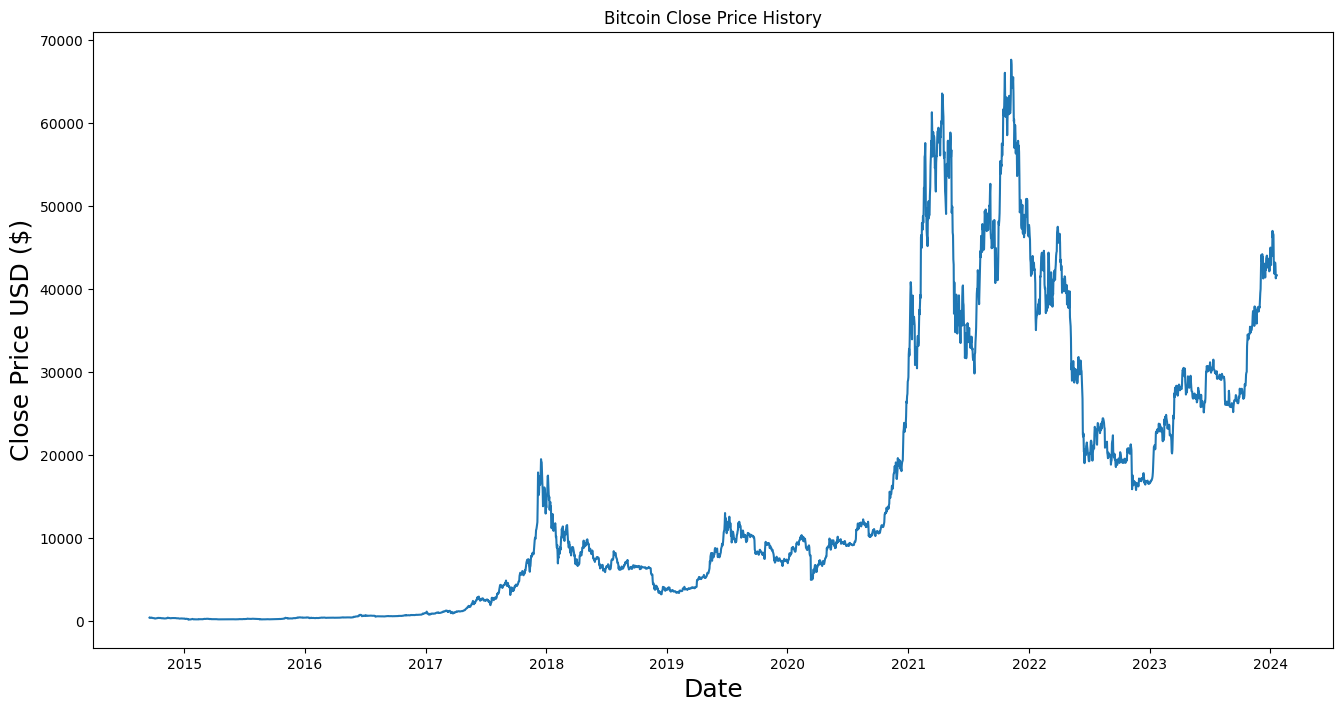

In [54]:
plt.figure(figsize=(16,8))
plt.title('Bitcoin Close Price History')
plt.plot(df['Date'], df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

## Data Preprocessing 

**Key Concept: Data Extraction**

Code: df.filter(['Close']).values

This single line performs two critical operations to prepare data for the AI:
1. Selection (.filter(['Close'])):
* What it does: Ignores columns like Open, High, Low, and Volume.
* Why: We are only interested in predicting the Closing price.
* Result: A Pandas DataFrame containing only one column.

2. Conversion (.values):**
* What it does: Strips away the "Table" format (headers, index numbers).
* Why: Neural networks (Math models) cannot read Excel/Table formats. They only understand raw
  matrices of numbers.
* Result: A Numpy Array (a raw list of floating-point numbers) ready for calculation.

In [55]:
data = df.filter(['Close'])

In [56]:
# Scale data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [57]:
joblib.dump(scaler, 'btc_scaler.gz')
print("Scaler saved to 'model/btc_scaler.gz'")

Scaler saved to 'model/btc_scaler.gz'


In [58]:
# Define lookback period (60 days)
prediction_days = 60

In [59]:
# Split into Training (80%) and Testing
training_data_len = int(np.ceil(len(scaled_data) * 0.8))
train_data = scaled_data[0:training_data_len, :]

In [60]:
# Create Sequences
x_train, y_train = [], []
for i in range(prediction_days, len(train_data)):
    x_train.append(train_data[i-prediction_days:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print("Training Data Created.")

Training Data Created.


## Model Building 

In [61]:
model = Sequential()

# Layer 1: Bidirectional LSTM
# Reads sequence forwards and backwards for better context
model.add(Bidirectional(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1))))
model.add(Dropout(0.2)) # Prevents overfitting

# Layer 2: Bidirectional LSTM
model.add(Bidirectional(LSTM(50, return_sequences=False)))
model.add(Dropout(0.2))

# Layer 3: Dense Layers
model.add(Dense(25))
model.add(Dense(1)) # Output is the predicted price

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [62]:
# Train the model 
# EarlyStopping: Stop training if validation loss doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("\nStarting Training...")
# We use a validation_split of 10% to monitor performance during training
history = model.fit(
    x_train, 
    y_train, 
    batch_size=32, 
    epochs=50, # Set high, EarlyStopping will stop it at the optimal point
    validation_split=0.1, 
    callbacks=[early_stop]
)

# Prepare Test Data
test_data = scaled_data[training_data_len - prediction_days: , :]
x_test = []
y_test = data.iloc[training_data_len:].values

for i in range(prediction_days, len(test_data)):
    x_test.append(test_data[i-prediction_days:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


Starting Training...
Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - loss: 0.0041 - val_loss: 0.0054
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 7.1394e-04 - val_loss: 0.0057
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 8.5592e-04 - val_loss: 0.0016
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 5.3644e-04 - val_loss: 0.0014
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 5.8861e-04 - val_loss: 0.0028
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 6.2839e-04 - val_loss: 0.0016
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 5.1368e-04 - val_loss: 0.0014
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 6.9162e-04 - val_loss: 0.0012
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 3.8792e-04 - val_loss: 0.0031
Epoch 12

In [64]:
# =================================================
# APPEND THIS TO THE BOTTOM OF train.py
# =================================================
from sklearn.metrics import r2_score, mean_absolute_error

# 1. RE-CREATE TEST DATA
# -------------------------------------------------
# We need the Scaled Data again to create the test set
# (Make sure 'scaled_data' and 'training_data_len' variables are still in memory)

test_data = scaled_data[training_data_len - prediction_days: , :]

x_test = []
y_test = data.iloc[training_data_len:].values  # The actual prices

for i in range(prediction_days, len(test_data)):
    x_test.append(test_data[i-prediction_days:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# 2. MAKE PREDICTIONS
# -------------------------------------------------
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) # Convert back to normal prices

# 3. CALCULATE R2 SCORE
# -------------------------------------------------
r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print("\n-----------------------------------")
print(f"R² Score: {r2:.4f}")  # 1.0 is perfect, 0.0 is bad
print(f"Mean Abs Error: ${mae:.2f}")
print("-----------------------------------")

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step

-----------------------------------
R² Score: 0.9764
Mean Abs Error: $904.96
-----------------------------------


In [1]:
model.save('btc_model.keras')
print("Model saved to 'model/btc_model.keras'")
print("Training Complete!")

NameError: name 'model' is not defined